In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from collections import Counter
from sklearn.preprocessing import LabelEncoder

#Introduction: describe the data, the task, and the challenges.





In this project we will attempt to predict which cousine a recipie is based on its ingredients.
For example, lets assume you have the following ingreadient list[tortilla, avacado, tomato, cilantro, garlic, chili powder, jalapeno, skirt steak, sour cream, cheese]. The learning model should be able to classify this as mexican cousine.



Lets start by importing and using paandas to load our training and test data.

In [ ]:
#load training and test data
df_train = pd.read_json('train.json')
df_test = pd.read_json('test.json')

#Look at the training data
df_train.head()


,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [ ]:
print('Training data shape: ', df_train.shape)
print('test data shape: ', df_test.shape)

Training data shape:  (39774, 3)
test data shape:  (9944, 2)


Now that we can see the data structure we can see that its fairly simple. It contains the following


1.   Id for each recipie in the dataset
2.   The type of cuisine each recipie is.
3.   A list of all the ingredients in each recipie.

Looking at the table we can try to extract some infromation from it. The first and most important thing to identify is how many different cusines there are and how many of each causine exists in the training dataset. This is important because we can use this as a baseline for how our model should perform.



# Baseline: Describe the baseline

Lets import and use matplot lib to create a table that can visualy represent the amount of cusisines in the dataset. This is going to help us get a better idea of the data we are working with and help us formulate a baseline.

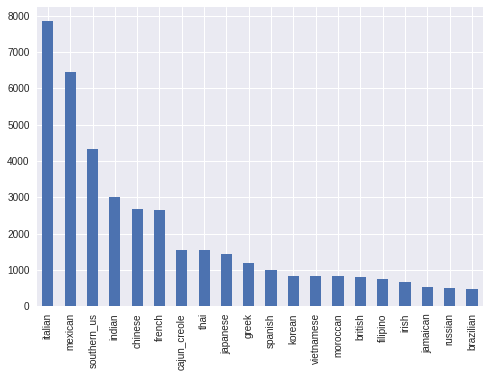

In [ ]:
#seaborn style sheet for looks
plt.style.use('seaborn')

#create a bar graph of the count of all cusinies
df_train['cuisine'].value_counts().plot(kind='bar')

As we can see, the majority of cusines are classified as italian, mexican, and southern_us. We can get more insight on the data by find the percentage that each causine holds. We do this my taking the amount of each cusisine and dividing it by the total amount of training data sets.

In [ ]:
#print the percentage of each value
print(df_train['cuisine'].value_counts()/ df_train.shape[0])


italian         0.197063
mexican         0.161865
southern_us     0.108614
indian          0.075502
chinese         0.067205
french          0.066526
cajun_creole    0.038870
thai            0.038694
japanese        0.035777
greek           0.029542
spanish         0.024865
korean          0.020868
vietnamese      0.020742
moroccan        0.020642
british         0.020214
filipino        0.018982
irish           0.016770
jamaican        0.013225
russian         0.012294
brazilian       0.011741
Name: cuisine, dtype: float64


Now that we have percentages we can see that:


1.   Italin holds 19.71% of the total
2.   Mexican holds 16.19% of the total
3.   Southern_us holds 10.86% of the total


We can use this information as the baseline for our model.


#Data Analysis: Understanding labels, features and plotting

Now that we have a baseline its time to get more insignt on the data by preforming some data analysis. Now that we know the most frequent cusisine we can also calculate the most frequent ingredients for each cusine. This information will be helpfull in identifying which ingredients belong to which cusisine.

In [ ]:
#list to count each instance
counters = {}

#for unique cusisine in the dataset
for i in df_train['cuisine'].unique():
  counters[i] = Counter()
  idx = (df_train['cuisine'] == i)
  for j in df_train[idx]['ingredients']:
    counters[i].update(j)

#print the most common ingredients for each cuisine
for i in df_train['cuisine'].unique():
  print("{}\t{}".format(i,counters[i].most_common(3)))

greek	[('salt', 572), ('olive oil', 504), ('dried oregano', 267)]
southern_us	[('salt', 2290), ('butter', 1255), ('all-purpose flour', 1222)]
filipino	[('salt', 421), ('garlic', 325), ('water', 310)]
indian	[('salt', 1934), ('onions', 1195), ('garam masala', 862)]
jamaican	[('salt', 332), ('onions', 173), ('water', 153)]
spanish	[('salt', 460), ('olive oil', 387), ('garlic cloves', 290)]
italian	[('salt', 3454), ('olive oil', 3111), ('garlic cloves', 1619)]
mexican	[('salt', 2720), ('onions', 1493), ('ground cumin', 1346)]
chinese	[('soy sauce', 1363), ('sesame oil', 915), ('salt', 907)]
british	[('salt', 407), ('all-purpose flour', 238), ('butter', 222)]
thai	[('fish sauce', 625), ('garlic', 414), ('salt', 396)]
vietnamese	[('fish sauce', 392), ('sugar', 344), ('salt', 264)]
cajun_creole	[('salt', 743), ('onions', 529), ('garlic', 370)]
brazilian	[('salt', 194), ('onions', 133), ('olive oil', 118)]
french	[('salt', 1203), ('sugar', 637), ('all-purpose flour', 593)]
japanese	[('soy sau

Now we have a list of the most common ingredients for each type of cuissine. We can make it more readable my converting it into a dataframe using pandas.

Using a visual representaiton of the data is necessary in order to identify patterns. Creating this table will allow us to see the top 10 ingredients and identify which are important which are prominent to a region.

In [ ]:
top_ingredients = pd.DataFrame([[items[0] for items in counters[cuisine].most_common(10)] for cuisine in counters],
            index=[cuisine for cuisine in counters],
            columns=['top {}'.format(i) for i in range(1, 11)])
top_ingredients

,top 1,top 2,top 3,top 4,top 5,top 6,top 7,top 8,top 9,top 10
greek,salt,olive oil,dried oregano,garlic cloves,feta cheese crumbles,extra-virgin olive oil,fresh lemon juice,ground black pepper,garlic,pepper
southern_us,salt,butter,all-purpose flour,sugar,large eggs,baking powder,water,unsalted butter,milk,buttermilk
filipino,salt,garlic,water,onions,soy sauce,pepper,oil,sugar,carrots,ground black pepper
indian,salt,onions,garam masala,water,ground turmeric,garlic,cumin seed,ground cumin,vegetable oil,oil
jamaican,salt,onions,water,garlic,ground allspice,pepper,scallions,dried thyme,black pepper,garlic cloves
spanish,salt,olive oil,garlic cloves,extra-virgin olive oil,onions,water,tomatoes,ground black pepper,red bell pepper,pepper
italian,salt,olive oil,garlic cloves,grated parmesan cheese,garlic,ground black pepper,extra-virgin olive oil,onions,water,butter
mexican,salt,onions,ground cumin,garlic,olive oil,chili powder,jalapeno chilies,sour cream,avocado,corn tortillas
chinese,soy sauce,sesame oil,salt,corn starch,sugar,garlic,water,green onions,vegetable oil,scallions
british,salt,all-purpose flour,butter,milk,eggs,unsalted butter,sugar,onions,baking powder,large eggs


Now that we have a table with the most common ingredients for each cusisine we can start to identify some patterns. The first thing to note is that salt is an ingredient that is in almost every recipie in our dataset and is almos the most prominent among most of them.

We can also see that soy sauce is the most common ingredient in asian cusisines including chinese, japanese and korean.

Now that we identified the most common ingredients per cusisine we can also identify the most unique ingredients per cusisine. Think of the following example


1.   Mirin and Sake are ingredients that are unique to japan
2.   Corn Torillas and Acocado are ingredients that are unique to mexico.

This information will be helpfull in helping us calssify a refion based on unique ingredients.



Lets start by taking a look at all the unique ingredients in the top_ingredients list since taking a look at all unique ingredients would be too much data to process.

In [ ]:
unique = np.unique(top_ingredients.values)
unique

array(['all-purpose flour', 'avocado', 'baking powder', 'baking soda',
       'black pepper', 'butter', 'buttermilk', 'cachaca',
       'cajun seasoning', 'carrots', 'cayenne pepper', 'chili powder',
       'coconut milk', 'corn starch', 'corn tortillas', 'cumin seed',
       'dried oregano', 'dried thyme', 'eggs', 'extra-virgin olive oil',
       'feta cheese crumbles', 'fish sauce', 'fresh lemon juice',
       'fresh lime juice', 'garam masala', 'garlic', 'garlic cloves',
       'ginger', 'grated parmesan cheese', 'green bell pepper',
       'green onions', 'ground allspice', 'ground black pepper',
       'ground cinnamon', 'ground cumin', 'ground ginger',
       'ground turmeric', 'jalapeno chilies', 'large eggs', 'lime',
       'milk', 'mirin', 'oil', 'olive oil', 'onions', 'paprika', 'pepper',
       'potatoes', 'red bell pepper', 'rice vinegar', 'sake', 'salt',
       'scallions', 'sesame oil', 'sesame seeds', 'shallots',
       'sour cream', 'soy sauce', 'sugar', 'tomatoes', 'un

#Models: Training, validation and test data.

Now that we have some usefull insight on the data that we are using we can now create a classification model.

I will use scikit-learn to create our first classification. The first step that we have to take is to encode out features into a matric.

We will be using count vectorizer to convert the colleciton of text to a matrix of token counts.

This is a sparse representation of the counts.

In [ ]:
cv = CountVectorizer()

Now that we have the count vectorizeor, we can tell it whihc features it should accept to build a binary matrix when ingredients are there.

In [ ]:
#create a new column in the data that includes all ingredients 
df_train['all_ingredients'] = df_train['ingredients'].map(";".join)

#create x_train with a binary representation of all possible ingredients
x_train = cv.fit_transform(df_train['all_ingredients'].values)

#print the shape of the matrix
x_train.shape

(39774, 3010)

Now we have created a binary representation of X_train. In this binary representation each cusisne has 3010 features where each feature is respresented as 0 or 1 if the ingredient is present or missing.

We will still need to encode the labes that represent each cusisine. We will do this by using sklearns label encoder.

In [ ]:
encoder = LabelEncoder()

Now we can encode target values Y. This way the target is a binary representaiton. Y will now become a vectoer 1-20 (for each type of cuisine) instead of a string. 

In [ ]:
y_train = encoder.fit_transform(df_train.cuisine)
print(encoder.classes_)
y_train

['brazilian' 'british' 'cajun_creole' 'chinese' 'filipino' 'french'
 'greek' 'indian' 'irish' 'italian' 'jamaican' 'japanese' 'korean'
 'mexican' 'moroccan' 'russian' 'southern_us' 'spanish' 'thai'
 'vietnamese']


array([ 6, 16,  4, ...,  8,  3, 13])

Now that we have a binary representation. We can now train a logistic regression model on the dataset

We can start by splitting the dataset so that out learning model will work on data that it has not seen.

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(x_train, y_train, test_size = 0.2)

Since we now have a training and test data set we can beggin to train or logistic regression model

In [ ]:
#assign a logistic regeression model
logistic_model = LogisticRegression()

#fit training data to model
logistic_model.fit(X_train, Y_train)

Print the accuracy of the model

In [ ]:

#check the score of the model
print('Accuracy Score: ', logistic_model.score(X_test, Y_test))


Accuracy Score:  0.7777498428661219


#Analysis: Conclusion & Error

Instead of printing a simple 2 x 2 confusion matruc we can actually print out the precision, recall, f1-score, and support for each unique type of cuisine.

We do this by using sklearns classification report

In [ ]:
Y_pred = logistic_model.predict(X_test)


cuisines = df_train['cuisine'].value_counts().index
print(classification_report(Y_test, Y_pred, target_names=cuisines))

              precision    recall  f1-score   support

     italian       0.74      0.63      0.68       101
     mexican       0.48      0.40      0.44       156
 southern_us       0.78      0.65      0.71       333
      indian       0.81      0.84      0.83       539
     chinese       0.73      0.58      0.65       154
      french       0.60      0.66      0.63       504
cajun_creole       0.77      0.72      0.74       253
        thai       0.85      0.87      0.86       569
    japanese       0.58      0.50      0.54       123
       greek       0.82      0.87      0.84      1572
     spanish       0.80      0.70      0.74       102
      korean       0.77      0.68      0.72       296
  vietnamese       0.81      0.80      0.81       175
    moroccan       0.89      0.92      0.91      1263
     british       0.83      0.70      0.75       164
    filipino       0.66      0.40      0.50       103
       irish       0.69      0.78      0.73       865
    jamaican       0.62    

We can see that most cuisines hold a precision of above 60% however there are some that dont such as japanese and mexican cuisine.

Being able to see these results allows us to produce a better of analysis and come up with different ways to improve our learning model.

We can also preform some error analysis by taking a look at a confusion matric that compares trye labels vc predicted labels.



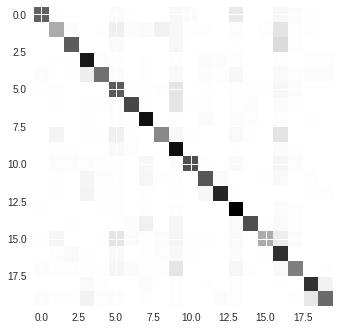

In [ ]:
cm = confusion_matrix(Y_test, logistic_model.predict(X_test))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.imshow(cm_normalized, interpolation='nearest')

Using this confusion matric we can identify some cusisines that get missclassified the two having the most issues being greek and irish. 

In conclusion we were able to produce obove average results using a logistic regression model with an accuracy of about 78%. This beats our baseline of around 20%.

We were able to have a in depth analysis of the data to create and train a learning model. In the future we can use the results of this model to build a better one. 